In [1]:
%matplotlib inline
import numpy as np
pi = np.pi

# Modeling the car physics

## Definitions

### Electrical
* $\tau$: motor torque, Nm
* $\omega$: motor rotational speed, rad/s
* $V$: voltage across the motor terminals (will be $u$ when we construct the controller)
* $I$: motor current
* $R$: Resistance of the motor windings
* $K_t$: Motor torque constant in $\frac{N m}{A}$
* $K_v$: Motor velocity constant in $\frac {V s}{radians}$

### Mechanical
* $v$: velocity of the car in m/s
* $a$: acceleration of the car in $\frac{m}{s^2}$
* $m$: mass of the car in kg
* $d$: drag coefficient of the car in $\frac{Ns}{m}$
* $F_{net}$: Net force on the car in N
* $F_m$: The force the wheels apply to the car in N. Proportional to motor torque.
* $r_w$: car wheel radius in m
* $G_r$: gear ratio, expressed as shaft gear/motor gear. Larger than 1.
* $\omega_{axle}$: rotational speed of the rear drive axle in rad/s
* $\tau_{axle}$: torque applied by motor/chain to the rear drive axle in Nm

## Modeling the motor
[DC motor modeling](https://pages.mtu.edu/~wjendres/ProductRealization1Course/DC_Motor_Calculations.pdf)

We will use the following equivalent circuit model for the brushed DC motor:

![motor model](dc-motor-equivalent-circuit.png "https://www.precisionmicrodrives.com/content/dc-motor-speed-voltage-and-torque-relationships/")

Ignoring the effects of the inductance, the fundamental equations are:
$$\tau = K_tI$$
$$V = V_{EMF} + IR$$
$$V_{EMF} = K_v \omega$$

Rearranging, we have:
$$V = K_v \omega + IR$$

or
$$I = \frac{V - K_v \omega}{R}$$

Plugging this back in, we arrive at the final equation for torque in terms of voltage and rotational speed:
$$\tau = K_t\frac{V - K_v \omega}{R} = -\frac{K_t K_v \omega}{R} + \frac{K_t V}{R}$$

### Converting motor torque and angular velocity to linear force and velocity
At the rear drive shaft we have
$$\omega_{axle} = \frac{\omega}{G_r}$$
$$\tau_{axle} = G_r \tau$$

Then
$$v = r_w \omega_{axle} = \frac{r_w \omega}{G_r}$$
$$F_m = \frac{\tau_{axle}}{r_w} = \frac{G_r}{r_w} \tau$$

Rewriting the first equation,
$$\omega = \frac{G_r}{r_w} v$$

## Modeling the car's physics
![Car model](car_sum_forces.png)

Using Newton's law:
$$ma = F_{net} = F_m - dv$$

Combining with the above motor modeling:
$$ma = \frac{G_r}{r_w} \tau - dv = \frac{G_r}{r_w}(-\frac{K_t K_v \omega}{R} + \frac{K_t V}{R}) - dv = \frac{G_r}{r_w}(-\frac{K_t K_v \frac{G_r}{r_w} v}{R} + \frac{K_t V}{R}) - dv $$

Simplifying
$$ma = -\frac{K_t K_v G_r^2 v}{r_w^2 R} v - dv + \frac{G_r K_t}{r_w R} V = -(\frac{K_t K_v G_r^2}{r_w^2 R} + d) v + \frac{G_r K_t}{r_w R} V$$

## The results
We have
$$\dot{v} = a = -(\frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}) v + \frac{G_r K_t}{r_w R m} V$$

Lumping everything into constants,
$$ \dot{v} = -\gamma_1 v + \gamma_2 V $$

where
$$\gamma_1 = \frac{K_t K_v G_r^2}{r_w^2 R m} + \frac{d}{m}$$
$$\gamma_2 = \frac{G_r K_t}{r_w R m}$$

#### Units of $K_v$
$K_v$ is given in $\frac{V}{RPM} = \frac{V}{\frac{rev}{min}} = \frac{V min}{rev}$. Converting: $\frac{V min}{rev} \frac{60 sec}{min} \frac{rev}{2 \pi radian} = \frac{V s}{radian}$ as desired.
 

In [2]:
#Define mechanical constants
m = 150   #150 Check this
Gr = 64/22 #Gear ratio
rw = 0.27/2 #Tire radius
d = 1  #Calculated with 1   #TODO: find what the real drag constant is

#Define electrical constants
R = 0.035  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms
Kv = 0.0132 * 60/(2*pi)
Kt = 0.1260  #0.1260 design


gamma_1 = Kt*Kv*Gr**2/(rw**2 * R*m) + d/m
gamma_2 = Gr*Kt/(rw*R*m)

print(gamma_1)
print(gamma_2)

1.4114314276727884
0.5171717171717172


# Creating the controller
Unfortunately, we do not have direct measurements of the car's velocity. We only measure the car's position with an encoder, so we will need an estimator to deduce the car's velocity from that. We will discuss this below, under Creating the Estimator.

It turns out that it is perfectly acceptable to do this - linear algebra shows that the overall system converges as fast as the slower of the regulator (our PI controller) and estimator. We shall design the estimator to converge much faster than the regulator, so we can ignore the effects of the estimator when designing the regulator.

## Definitions
### Variables
 * $x$ is our system state variable velocity in $\frac{m}{s}$. This is usually a vector, but our system is first-order, so it is a scalar.
 * $\hat{x}$ is our estimated velocity in $\frac{m}{s}$ from the estimator.
 * $y$ is our system output variable velocity in $\frac{m}{s}$ (Yes, $x$ and $y$ are the same)
 * $u$ is the voltage output from the controller in volts. The same thing as $V$ before.
 * $\sigma$ is the error integral in $\frac{m}{s} s = m$
 * $r$ is the car's target (reference) velocity
 * $u_{ref}$ and $x_{ref}$ are reference values of $u$ and $x$ derived from plant inversion
 
### Constants
 * $n$ is the system order (1 for us).
 * $A$, $B$, $C$ are all matricies that represent the car's physics
 * $k_{1}$ is the P gain of our controller. This is usually a matrix, but $x$ and $u$ are scalars so $k_{1}$ is scalar too.
 * $k_{2}$ is the I gain of our controller. This is a scalar.

## Converting the model to state-space form

In order to more easily use our control-design machinery, we shall place the model in state-space form:
$$ \dot{x} = A x + B u $$
$$ y = C x $$

In [3]:
A = -gamma_1
B = gamma_2
C = 1

## The controller equations
We shall implement PI trajectory-following control with state feedback

$$ u = u_{ref} - k_{1} (x - x_{ref}) - k_{2} \sigma $$
$$ \dot{\sigma} = y - r $$

We have no need of an estimator because we directly measure the state variable, velocity, with our speed sensor.

## Determining the gains $k_{1}$ and $k_{2}$
It can be shown that the overall system eigenvalues, which control how fast the car settles to the desired velocity, are given by the eigenvalues of
$$\mathscr{A} - \mathscr{B}\mathscr{K}$$

There are $$n + 1$$ eigenvalues to place.

$\mathscr{A} = \begin{pmatrix}A & 0 \\C & 0\end{pmatrix}$ is a square matrix, $\mathscr{B} = \begin{pmatrix}B \\ 0\end{pmatrix}$ is a column vector, and 
$\mathscr{K} = \begin{pmatrix}k_{1} & k_{2}\end{pmatrix}$ is a row vector.

### Check for controllability and commandability
We can place the eigenvalues of $\mathscr{A} - \mathscr{B}\mathscr{K}$ anywhere we want provided that $A$ and $B$ are controllable and commandable, which is identical to checking if $\mathscr{A}$ and $\mathscr{B}$ are controllable.

$\mathscr{A}$ and $\mathscr{B}$ are controllable if and only if $|\mathscr{C}| \neq 0$, where $\mathscr{C}$ is a square matrix:
$$\mathscr{C} = \begin{pmatrix} B & AB & \cdots & A^{n-1}B\end{pmatrix}$$

In our case, the system is controllable and commandable, so we may continue with the design:
$$|\mathscr{C}| = |\begin{pmatrix} B \end{pmatrix}| = |B| = \gamma_{2} \neq 0$$

### Calculation of $\mathscr{K}$
Fortunately, Scipy can do the math for us if we tell it $\mathscr{A}$, $\mathscr{B}$, and where we want the poles to be (this is a key design parameter). See [the documentation for the function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.place_poles.html).

In [4]:
from scipy.signal import place_poles

A_script = np.array([[A, 0],
                     [C, 0]])
B_script = np.array([[B],
                     [0]])

desired_poles = [-2, -2.01]

results = place_poles(A_script, B_script, desired_poles)
#Results is returned as a 2-d matrix, when we want a 1-d matrix. The [0] converts it.
k_1, k_2 = K_script = results.gain_matrix[0]
actual_poles = results.computed_poles

print("k_1 =", k_1, " k_2 =", k_2)   #the gains
print(actual_poles) #where the poles actually ended up. Should be very close to our desired poles

k_1 = 5.024575950397579  k_2 = 7.773046874998515
[-2.01 -2.  ]


## Creating $u_{ref}$ and $x_{ref}$ via plant inversion
In general, the inverse plant is also given by a state-space model
$$ \dot{x_{inv}} = A_{inv} x_{inv}+ B_{inv} u_{inv} $$
$$ y_{inv} = C_{inv} x_{inv} + D_{inv} u_{inv}$$

where
 * $y_{inv} = \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix}$ is the output of the inverse system, which will be used in the controller. $x_{ref}$ is a vector the same size as $x$.
 * $x_{inv}$ is NOT $x_{ref}$. It is some artificial state used in the system.
 * $u_{inv} = \begin{pmatrix}r \\ \dot{r} \\ \vdots \\ r^{(\rho)}\end{pmatrix}$, the input to the inverse system, is derivatives of the reference signal.

and our job is to determine $A_{inv}$, $B_{inv}$, $C_{inv}$, and $D_{inv}$.
 
**Do not be confused!** $y_{inv}$, $x_{inv}$, and $u_{inv}$ are not the same as $y$, $x$, or $u$.

### Determine the relative degree of the plant, $\rho$
The relative degree is $\rho =$ Number Plant Poles $-$ Number Plant Zeros, where $1 \leq \rho \leq n$ (provided plant is controllable and commandable, as we already showed). For us, $n = 1$, so $1 \leq \rho \leq 1$, or $\rho = 1$.

In [5]:
system_order = 1

### Variable change to normal form
Our goal is to find two matricies $M$ and $N$. M is given explicitly, while N is defined implicitly (N is not unique) by satisfying the following properties:
 * $M = \begin{pmatrix}CA^{0} \\ CA^{1} \\ \vdots \\ CA^{\rho - 1}\end{pmatrix}$
 * $S = \begin{pmatrix}M \\ N\end{pmatrix}$ is square
 * $|S| \neq 0$ (So S is invertible and can be used to change variables).

#### For our system
$$M = \begin{pmatrix} CA^{0} \end{pmatrix} = C = 1$$

and $N$ has no size at all:
$$S = \begin{pmatrix} M \end{pmatrix} = 1$$

### Inverse variable change
Using the $S$ found above, find

$$S^{-1} = \begin{pmatrix}Q & R\end{pmatrix}$$

where $Q$ is a $n \times \rho$ matrix and $R$ is a $n \times (n -\rho)$ matrix.

#### For our system
$n = \rho = 1$, so $R$ is a $1 \times 0$ matrix and 
$$S^{-1} = 1 = \begin{pmatrix}Q & R\end{pmatrix} = \begin{pmatrix} Q \end{pmatrix}$$

In [6]:
Q = 1

### Putting it all together: 
Because $N$ and $R$ do not exist in our case, $A_{inv}$, $B_{inv}$, $C_{inv}$ do not exist and the inverse plant has no state variables $x_{inv}$. The model becomes
$$ \begin{pmatrix}u_{ref} \\ x_{ref}\end{pmatrix} = y_{inv} = D_{inv} u_{inv} = D_{inv} \begin{pmatrix}r \\ \dot{r}\end{pmatrix}$$

Using the formula for $D_{inv}$,
$$\gamma_{inv} = \frac{1}{C A^{\rho-1} B} = \frac{1}{C B}$$
$$D_{inv} = \begin{pmatrix} -\gamma_{inv} C A^{\rho} Q & \gamma_{inv} \\ Q & 0\end{pmatrix} = \begin{pmatrix} -\gamma_{inv} C A Q & \gamma_{inv} \\ Q & 0\end{pmatrix}$$

Unpacking the matrix, we find

$ u_{ref} = (-\gamma_{inv} C A Q) r + (\gamma_{inv}) \dot{r} =$ k_inv_r_to_u $r + $ k_inv_r_dot_to_u $\dot{r}$

$ x_{ref} = Q r =$ k_inv_r_to_x $r$



In [7]:
#BEWARE: Python uses @ for matrix multiplication. We use * here because the matricies are 1-D
gamma_inv = 1/(C * B)

k_inv_r_to_u = -gamma_inv * C * A * Q
k_inv_r_dot_to_u = gamma_inv
k_inv_r_to_x = Q

print(k_inv_r_to_u)
print(k_inv_r_dot_to_u)
print(k_inv_r_to_x)

2.7291349871016806
1.93359375
1


# Creating the estimator
In the previous section we ignored the car's position, focusing only on its velocity and acceleration. However, we can't do that any more because our encoder measures distance traveled. We need to extend our physics model from a first-order system to a 2nd-order system and add the car's position $pos$ to ur new state vector $x_e$.

## Definitions
### Variables
Hats indicate estimates.
 * $x$ is our true velocity in $\frac{m}{s}$.
 * $pos$ is our true position in $m$.
 * $x_e = \begin{pmatrix}pos \\ x\end{pmatrix}$ is the true state - NOT TO BE CONFUSED with $x$.
 * $\hat{x}$ is our estimated velocity in $\frac{m}{s}$.
 * $\hat{pos}$ is our estimated position in $m$.
 * $\hat{x_e} = \begin{pmatrix}\hat{pos} \\ \hat{x}\end{pmatrix}$ is the estimator's state - NOT TO BE CONFUSED with $\hat{x}$.
 * $enc$ is the encoder's measurement of the position (measurement of $pos$).
 
### Constants
 * $A_e$, $B_e$, $C_e$ are all matricies that represent the car's physics. These are not the same as $A$, $B$, $C$ from before
 * $L$ is the regulator gain matrix

## Modeling the car's position
In order to expand our system model from $x$ to $x_e$, we need to determine the derivative of the position in terms of other state variables and control inputs. This is very easy:
$$\dot{pos} = x$$

We can now place our new, expanded system in the state-space form
$$ \dot{x_e} = A_e x_e + B_e u_e $$
$$ pos = C_e x_e $$

Expanding the state variable $x_e$, we see
$$\begin{pmatrix} \dot{pos} \\ \dot{x} \end{pmatrix} = \begin{pmatrix}0 & 1 \\0 & -\gamma_1\end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix} + \begin{pmatrix}0 \\ \gamma_2\end{pmatrix} u$$
$$enc = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix}pos \\ x\end{pmatrix}$$

In [8]:
#Unlike matlab, Numpy does not default to 2-D arrays unless you make your arrays explicitly 2-D

A_e = np.array([[0, 1],
                [0, -gamma_1]])
B_e = np.array([[0],
                [gamma_2]])
C_e = np.array([[1, 0]])

## The estimator equations
We shall estimate the state variable $x_e$ using the following formula. Roughly speaking, it assumes the state evolves in time as given by the above equations and then adds a corrective term to account for any discrepancies.
$$\dot{\hat{x_e}} = A_e \hat{x_e} + B_e u - L(C_e \hat{x_e} - enc)$$

Rewriting
$$\dot{\hat{x_e}} = (A_e -L C_e)\hat{x_e} + B_e u + L enc$$

## Determining the gain matrix L
It can be shown that estimator's share of the overall system eigenvalues is given by the eigenvalues of 
$$ A_e - L C_e$$

Furthermore, using system duality, these eigenvalues are identical to the eigenvalues of
$$ A_e^T - C_e^T L^T $$

where the last equation is significant because it permits us to use 'scipy.signal.place_poles' as before.

We can use 'place_poles' to place the poles of $A - L C$ anywhere we please provided the system is observable (we omit checking this).

In [9]:
desired_estimator_poles = [-20, -20.01]

est_results = place_poles(A_e.T, C_e.T, desired_estimator_poles)
L = est_results.gain_matrix.T   #results is L.T, so we transpose again to get L
actual_poles = est_results.computed_poles
print(L, '\n')
print(actual_poles)

[[ 38.59856857]
 [345.72076725]] 

[-20.01 -20.  ]


# Implementation of the controller

## Dealing with the speed sensor

### Units of velocity
In the above analysis we assumed that our speed sensor gave us the car's true velocity in $\frac{m}{s}$. This is not the case: we are given the velocity in $\frac{magnets}{s}$. In software, before using the calculated speed in our controller, we will have to convert the velcity to $\frac{m}{s}$.

### Discretization of velocity
Our speed sensor can only count a discrete number of magnets per unit time. So if the time interval over which we measure speed is 1 ms, and we can only measure 0, 1, 2, ... magnets during that interval, our speed will be 0, 1000, 2000, 3000, ... magnets/sec with nothing in-between. This is not what our controller assumes: we assume that our speed sensor gives continuous speed measurements. We need to ensure we have enough magents on the rear axle, and we measure speed requencly enough, that we have sufficient resolution for our controller.

## Trapezoidal speed control
Imagine we start at a commanded speed of 0 and Software then commands a speed of $r = 15 \frac{m}{s}$. Assuming our controller runs at 100 Hz, this would result in $\dot{r} = \frac{15 \frac{m}{s}}{0.01 s} = 1500 \frac{m}{s^2}$, an incredibly high acceleration, which would result in an incredibly high commanded voltage.

Worse, this problem persists even if Software limits their acceleration to reasonable values: Software only provides us with speed updates at 10 Hz while our controller runs at 100+Hz, so on the controller timesteps when we get no new velocity $\dot{r} = 0$, while on the timesteps when we do get new velocities $\dot{r}$ is very large.

That is unrealistic. We must smooth the stair-stepped velocities we recieve. The way to do this is to implement an acceleration limit on $r$: insted of saying $r = r_{software}$, we keep $r$ and $r_{software}$ separate. Then, while $\frac{r_{software} - r}{T} > a_{max}$, we say $r = r + T a_{max}$, slowly increasing our reference velocity. This creates a trapezoidal-looking $r$ in response to a step increase in $r_{software}$ - hence the name.

### Finding the maximum acceleration
We are limited by two factors: the competition limits us to a maximum power of 10kW and the controller has a maximum motor current of $I_{motor,max} = 300 A$. The power limit caused us to configure the motor controller not to draw more than $I_{batt,max} = 200 A$ from the batteries.

Assuming a lossless controller, that means that the maximum current is given by
$$I_{max} = \mathrm{min}(I_{motormax}, \frac{V_{batt}I_{batt,max}}{V_{motor}})$$

As long as $V_{motor} < \frac{V_{batt}I_{batt,max}}{I_{motor,max}}$, the motor current limit will be the limiting factor. This back-EMF threshold corresponds to a velocity of
$$v = \frac{r_w \omega}{G_r} = \frac{r_w}{G_r K_v} V$$

As long as the car is moving slower than that,
$$I_{max} = I_{motor,max}$$

Therefore, the maximum acceleration is given by
$$a_{max} = \frac{F_{net,max}}{m} \approx \frac{F_{motor,max}}{m} = \frac{G_r}{m r_w} \tau_{max} = \frac{G_r K_t}{m r_w} I_{motor,max}$$
where the approximation is due to our neglecting the drag term included in $F_{net}$.

In [10]:
max_motor_amps = 300
max_battery_amps = 200
V_batt = 48   #Assume 48

meters_per_sec_per_V = rw/(Gr*Kv)

car_top_speed = gamma_2/gamma_1 * V_batt   #Using the differential equation above, if acceleration = 0 this holds:

V_crossover = V_batt*max_battery_amps/max_motor_amps
vel_crossover = meters_per_sec_per_V * V_crossover
a_max = Gr*Kt/(m*rw) * max_motor_amps

print("car's top speed:", car_top_speed)
print("Crossover voltage:", V_crossover)
print("velocity at crossover (m/s):", vel_crossover)
print("Maximum acceleration below crossover (m/s^2):", a_max)

car's top speed: 17.58799041705724
Crossover voltage: 32.0
velocity at crossover (m/s): 11.780972450961725
Maximum acceleration below crossover (m/s^2): 5.43030303030303


# Simulation
Now simulate the control scheme using the forward Euler method.
$$v[k+1] = v[k] + dt\frac{\mathrm{d}v}{\mathrm{d}t} = v[k] +dt(-\gamma_1 v[k] + \gamma_2 u[k])$$

While recording the position is not required by our model, doing so means we can simulate the discretization effect of the encoder.
$$position[k+1] = position[k] + dt * v$$

## Non-idealities simulated
Critically, this iteration of the simulation assumes that we can use the motor as a brake (regenerative braking). If this is not the case, we need to heavily modify the simulation for accurate results.
### Currently implemented
* The current + voltage limits of the controller
* Variations in parameters
* Finite update rate of controller (but we set it high)
* Discretizing effect of the encoder

### To implement
* Anything to do with brakes

### Not modeled
* Time delays to the brakes
* Motor inductance (Time constant is $\frac{L}{R} = 5 ms$)
* Any delays/imperfections in sending an analog signal to the controller

In [11]:
#Read in the CSV of commanded velocities
import csv
ns_per_sec = 1e9
with open('software_commanded_vel.csv') as velocity_csv:
    velocity_reader = csv.reader(velocity_csv, delimiter=',')
    next(velocity_reader)   #Skip first line, the headers
    software_velocity_times_commands = np.asarray([(int(line[0]), float(line[1])) for line in velocity_reader])
software_velocity_times_commands[:,0] /= ns_per_sec     #Convert times from ns to seconds
software_velocity_times_commands[:,0] -= software_velocity_times_commands[0,0]   #Make time start at 0

print(software_velocity_times_commands)

#Remember the last time and index we were ordered to fe
last_gotten_idx = 0
last_gotten_time = 0
def get_software_vel(time):
    '''
    Gets the last command software sent at the given time.
    Remembers the index of the last time it was called for increased efficiency in case time is monotonically increasing
    '''
    global last_gotten_idx
    global last_gotten_time
    
    if time > last_gotten_time:
        idx = last_gotten_idx
    else:
        idx = 0

    while software_velocity_times_commands[idx + 1, 0] < time:
        idx += 1
    
    last_gotten_idx = idx
    last_gotten_time = time
    return software_velocity_times_commands[idx, 1]

print(get_software_vel(0))

[[0.00000000e+00 4.00374116e-01]
 [4.00000000e-02 8.00374116e-01]
 [8.90000000e-02 1.10037412e+00]
 ...
 [5.55270000e+01 1.12442532e+01]
 [5.55570000e+01 0.00000000e+00]
 [6.55570000e+01 0.00000000e+00]]
0.400374116174075


In [12]:
#Define simulation physics parameters not already defined above
min_voltage = 0

start_velocity = 0

simulate_encoder_effect = True  #Simulate discretizing effect of encoder or not.
magnets_on_shaft = 24

dt = 5e-5  #Timestep
end_time = software_velocity_times_commands[-1,0]

#Define controller parameters (so we can tweak them)
controller_loop_time = 1e-3   #How frequently (in s) the controller runs

#For PI control
k_1_sim = k_1
k_2_sim = k_2

#For the estimator. We unpack the L matrix for easier use in our scalar equations
L_pos = float(L[0])
L_vel = float(L[1])

gamma_1_sim = gamma_1
gamma_2_sim = gamma_2

#For plant inversion
use_feedforward_control = True    #Disables feedforward (result is 0)
k_inv_r_to_u_sim = k_inv_r_to_u
k_inv_r_dot_to_u_sim = k_inv_r_dot_to_u
k_inv_r_to_x_sim = 1

controller_accel_limit = 0.75 * 5.43030303030303   #Some 'discount' factor times the true max acceleration

controller_V_batt = 48

sim_controller_current_limits = True

#Define data logging arrays
times, dt = np.linspace(0, end_time, num = round(end_time/dt), retstep=True)  #array of times
vel_kart_arr = np.zeros(len(times))  #actual kart velocity
estimated_vel_arr = np.zeros(len(times))
vel_trapezoidal_arr = np.zeros(len(times)) #Result of our trapezoidal approximation to software's commands
software_command_velocities_at_timestep_arr = np.zeros(len(times))  #We have Software's velocities at random times they chose - map into our array so we can plot
voltage_cmd_arr = np.zeros(len(times)) #The voltage command
voltage_realized_arr = np.zeros(len(times))  #The real voltage sent to the motor
brake_cmd_arr = np.zeros(len(times)) #The brake command
error_integral_effect_arr = np.zeros(len(times))  #The voltage commanded by the error integral


C:\Users\Peter\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [13]:
#Now write the estimator using the Forward Euler approximation of the equations above
est_pos = 0
est_vel = 0

def estimate_vel(delta_t, encoder_pos, voltage_cmd):
    #This implements the estimator equation above after unpacking it to scalar form (for easier transfer to C++)
    #Use the Forward Euler method
    global est_pos
    global est_vel
    
    new_est_pos = est_pos +  delta_t * (est_vel - L_pos*(est_pos - encoder_pos))
    new_est_vel = est_vel + delta_t * (-gamma_1_sim*est_vel + gamma_2_sim*voltage_cmd - L_vel*(est_pos - encoder_pos))
    est_pos = new_est_pos
    est_vel = new_est_vel
    return est_vel


In [14]:
#Now write the controller
error_integral = 0
trapezoidal_target_velocity = 0

def gen_control_signals(delta_t, est_vel, software_cmd_vel):
    '''
    The master controller function. Returns the commanded motor voltage and brake signals
    '''
    global trapezoidal_target_velocity
    global error_integral
    
    #Get target velocity + accel
    trapezoidal_target_velocity, commanded_accel = gen_target_vel_accel(delta_t, trapezoidal_target_velocity, software_cmd_vel)
    
    #Get feedforward reference values
    voltage_ref, vel_ref = gen_feedforward_reference(trapezoidal_target_velocity, commanded_accel)
    
    #Get voltage command
    voltage_command = gen_PI_control_voltage(voltage_ref, vel_ref, est_vel, error_integral)
    
    #Update error integral
    error_integral += delta_t * conditional_integration(est_vel, trapezoidal_target_velocity, voltage_command)
    
    return voltage_command, 0  #No brakes for now...
    
def gen_target_vel_accel(timestep, last_trapezoidal_vel, software_cmd_vel):
    #Limit our maximum acceleration in case Software gives us a step as discussed above.
    max_delta_v = timestep * controller_accel_limit
    trapezoidal_target_vel = min(max(software_cmd_vel, last_trapezoidal_vel - max_delta_v), last_trapezoidal_vel + max_delta_v)
    commanded_accel = (trapezoidal_target_vel - last_trapezoidal_vel)/timestep
    return trapezoidal_target_vel, commanded_accel

def gen_feedforward_reference(target_vel, target_accel):
    if not use_feedforward_control:
        return 0, 0
    #Generate the feedforward reference commands as discussed above
    voltage_ref = k_inv_r_to_u_sim * target_vel + k_inv_r_dot_to_u_sim * target_accel
    vel_ref = k_inv_r_to_x_sim * target_vel
    return voltage_ref, vel_ref

def gen_PI_control_voltage(voltage_ref, vel_ref, current_vel, err_integral):
    return voltage_ref - k_1_sim * (current_vel - vel_ref) - k_2_sim * err_integral

def conditional_integration(curr_vel, target_vel, voltage_cmd):
    #Calculates sigma dot. Returns 0 if we are saturated to avoid windup
    if voltage_cmd < 0 or voltage_cmd > controller_V_batt:
        return 0
    return curr_vel - target_vel

In [15]:
def get_true_voltage(true_speed, commanded_voltage):
    '''
    Calculates the effects of the controller's current limit on the voltage output by the controller, as described above
    '''
    if not sim_controller_current_limits:
        return commanded_voltage
    
    V_back_emf = true_speed/meters_per_sec_per_V
    if V_back_emf > 0:
        I_max = min(max_motor_amps, V_batt*max_battery_amps/V_back_emf)
    else:
        I_max = max_motor_amps
    
    #Check voltage won't cause controller to exceed current limit
    if commanded_voltage > V_back_emf + R*I_max:
        commanded_voltage = V_back_emf + R*I_max
    elif commanded_voltage < V_back_emf - R*I_max:
        commanded_voltage = V_back_emf - R*I_max
    
    #Now check controller voltage limit
    if commanded_voltage > V_batt:
        return V_batt
    elif commanded_voltage < 0:
        return 0
    #Voltage isn't clipped
    return commanded_voltage

def get_encoder_pos(current_pos):
    '''
    Calculates the estimated position as determined by the encoder. This may cause serious discretization of the speed values
    '''
    wheel_circumference = 2*pi*rw
    magnets_per_m = magnets_on_shaft/wheel_circumference
    
    return round(current_pos * magnets_per_m)/magnets_per_m

#Now write the simulation code
command_voltage = 0
command_brakes = 0
last_controller_execution = 0
last_encoder_speed_calc_time = 0
car_true_vel = start_velocity
car_true_position = 0
last_encoder_read_position = 0
encoder_est_speed = 0

for i in range(len(times)):
    time = times[i]
    
    #Find software's current vel
    software_vel_cmd = get_software_vel(time)
    
    #Execute the controller
    if time - last_controller_execution > controller_loop_time:
        timestep = time - last_controller_execution
        
        if simulate_encoder_effect:
            encoder_pos = get_encoder_pos(car_true_position)
            encoder_est_speed = estimate_vel(timestep, encoder_pos, command_voltage)
        else:
            encoder_est_speed = car_true_vel
        
        command_voltage, command_brakes = gen_control_signals(timestep, encoder_est_speed, software_vel_cmd)
        
        last_controller_execution = time
    
    #Bound the control signals
    true_voltage = get_true_voltage(car_true_vel, command_voltage)
    
    #Car physics:
    car_true_vel += dt*(-gamma_1*car_true_vel + gamma_2*true_voltage)
    car_true_position += dt*car_true_vel
    
    #Now do the logs
    vel_kart_arr[i] = car_true_vel
    estimated_vel_arr[i] = encoder_est_speed
    vel_trapezoidal_arr[i] = trapezoidal_target_velocity
    software_command_velocities_at_timestep_arr[i] = software_vel_cmd
    voltage_cmd_arr[i] = command_voltage
    brake_cmd_arr[i] = command_brakes
    voltage_realized_arr[i] = true_voltage
    error_integral_effect_arr[i] = -k_2_sim * error_integral
    
    
    
    
    

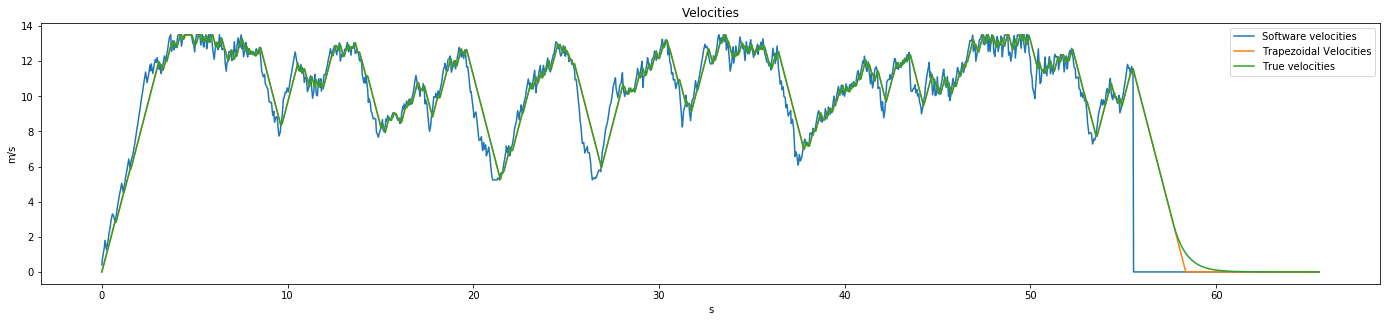

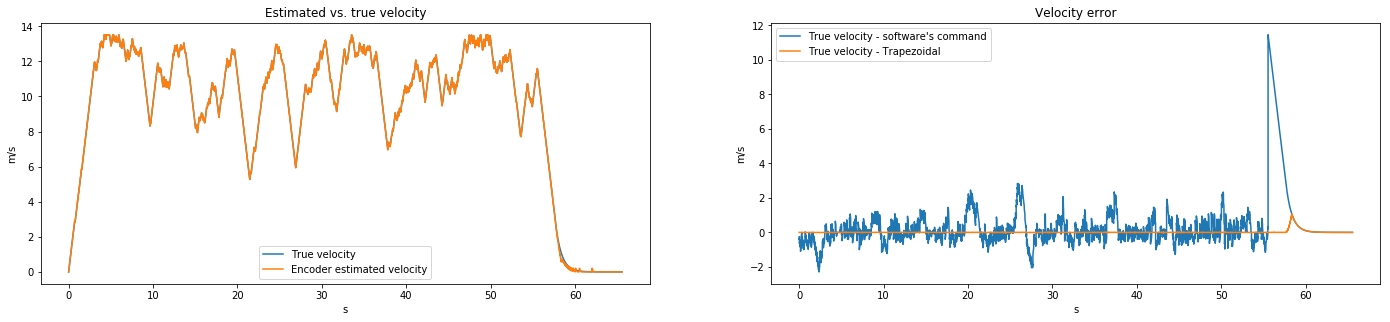

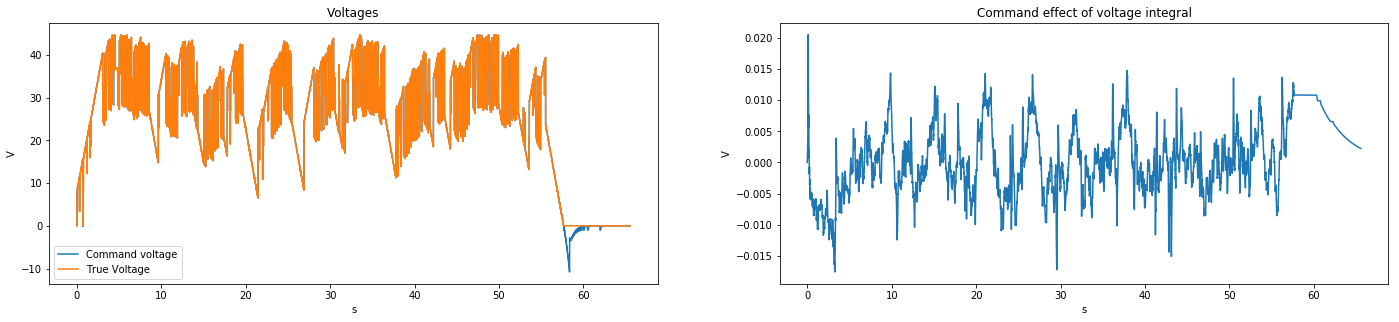

In [16]:
#Plots!
import matplotlib.pyplot as plt
plot_resolution = 10    #Only plot one of every [this] values to accelerate plotting

times_to_plot = times[::plot_resolution]
true_velocities_to_plot = vel_kart_arr[::plot_resolution]

plt.figure(1, figsize=(24, 4.8))
plt.plot(software_velocity_times_commands[:,0], software_velocity_times_commands[:,1])
plt.plot(times_to_plot, vel_trapezoidal_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot)

plt.title("Velocities")
plt.ylabel("m/s")
plt.xlabel("s")
plt.legend(['Software velocities', 'Trapezoidal Velocities', 'True velocities'])

plt.show()

plt.figure(2, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, true_velocities_to_plot)
plt.plot(times_to_plot, estimated_vel_arr[::plot_resolution])

plt.title("Estimated vs. true velocity")
plt.legend(['True velocity', "Encoder estimated velocity"])
plt.ylabel("m/s")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, true_velocities_to_plot - software_command_velocities_at_timestep_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot - vel_trapezoidal_arr[::plot_resolution])

plt.title("Velocity error")
plt.legend(["True velocity - software's command", 'True velocity - Trapezoidal'])
plt.ylabel("m/s")
plt.xlabel("s")

plt.show()

plt.figure(3, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, voltage_cmd_arr[::plot_resolution])
plt.plot(times_to_plot, voltage_realized_arr[::plot_resolution])

plt.title("Voltages")
plt.ylabel("V")
plt.xlabel("s")
plt.legend(['Command voltage', 'True Voltage'])

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, error_integral_effect_arr[::plot_resolution])

plt.title("Command effect of voltage integral")
plt.ylabel("V")
plt.xlabel("s")
plt.show()